In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
import os.path
from utils import ScalarEncoder, make_dataset, load_model, infer_ensemble, all_subdirs_of
from matplotlib import pyplot as plt

In [2]:
# loading model from the latest trained model
all_subdirs = all_subdirs_of("./logs")
latest_subdir = max(all_subdirs, key=os.path.getmtime)
print("loading model from: " + latest_subdir)
networks = load_model(os.path.join(latest_subdir, "models"))
# networks = load_model(os.path.join("logs/2017-11-09-15-56-29", "models"))
# scalar encoder for incident angles
encoder = ScalarEncoder(100, 30, 45)

print("Loading training set")
train_df = pd.read_json("data/train.json")
train_df["band_1"] = train_df["band_1"].apply(lambda x: np.array(x).reshape(75, 75))
train_df["band_2"] = train_df["band_2"].apply(lambda x: np.array(x).reshape(75, 75))
train_df["inc_angle"] = pd.to_numeric(train_df["inc_angle"], errors="coerce")
train_dataset = make_dataset(train_df, encoder, transforms=None, test=False)
del train_df

loading model from: ./logs/2017-11-10-16-50-36


Loading training set


In [5]:
print("Running train data")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_pred_mean = torch.FloatTensor()
train_pred_std = torch.FloatTensor()

for data_target in tqdm_notebook(train_loader, total=len(train_loader)):
    out_mean, out_std = infer_ensemble(data_target, networks, trial_per_sample=10)
    train_pred_mean = torch.cat((train_pred_mean, torch.FloatTensor([out_mean])), 0)
    train_pred_std = torch.cat((train_pred_std, torch.FloatTensor([out_std])), 0)
    val_target_var = data_target[0][1].float().cuda()

train_pred_mean.squeeze_()
train_pred_std.squeeze_()

Running train data


A Jupyter Widget

In [6]:
# Adjust the mean according to the std
prob_out_adjusted = (1 - 2 * train_pred_std) * (train_pred_mean - 0.5) + 0.5
prob_out_adjusted = torch.min(torch.max(train_pred_mean, torch.FloatTensor([0.01])), torch.FloatTensor([0.99]))

[   0.    0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    2.
    3.    2.    2.    3.    4.    0.    4.    8.    5.    7.    9.   11.
   27.   28.   30.   55.   91.  460.]


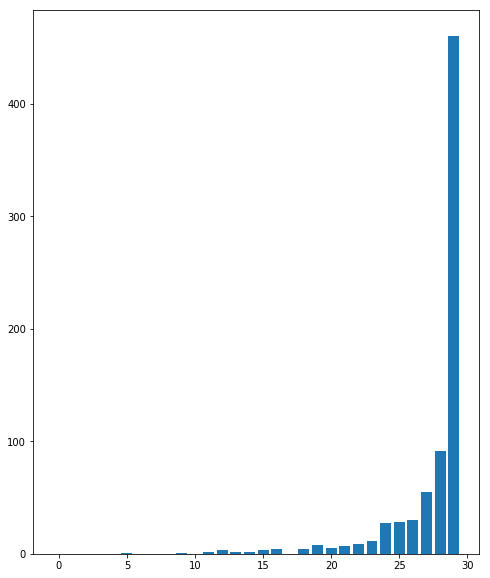

In [29]:
targets = train_dataset.datasets[0].targets[0].float()
non_zero_idx = targets.nonzero().squeeze_()
lift_data = torch.mul(train_pred_mean[non_zero_idx], targets[non_zero_idx])
list_hist = torch.histc(lift_data, bins=30, min=0, max=1, out=None).cpu().numpy()
print(list_hist)
plt.figure(figsize=(8, 10))
plt.bar(np.arange(0, 30), list_hist)
plt.show()